***

In [1]:
# all_times <- list()  # store the time for each chunk
# knitr::knit_hooks$set(time_it = local({
#   now <- NULL
#   function(before, options) {
#     if (before) {
#       now <<- Sys.time()
#     } else {
#       res <- difftime(Sys.time(), now, units = "secs")
#       all_times[[options$label]] <<- res
#     }
#   }
# }))
# knitr::opts_chunk$set(
#   tidy = TRUE,
#   tidy.opts = list(width.cutoff = 95),
#   message = FALSE,
#   warning = FALSE,
#   time_it = TRUE
# )

# Setup the Seurat Object

For this tutorial, we will be analyzing the a dataset of Peripheral Blood Mononuclear Cells (PBMC) freely available from 10X Genomics. There are 2,700 single cells that were sequenced on the Illumina NextSeq 500. The raw data can be found [here](https://cf.10xgenomics.com/samples/cell/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz).

We start by reading in the data. The `Read10X()` function reads in the output of the [cellranger](https://support.10xgenomics.com/single-cell-gene-expression/software/pipelines/latest/what-is-cell-ranger) pipeline from 10X, returning a unique molecular identified (UMI) count matrix. The values in this matrix represent the number of molecules for each feature (i.e. gene; row) that are detected in each cell (column).

We next use the count matrix to create a `Seurat` object. The object serves as a container that contains both data (like the count matrix) and analysis (like PCA, or clustering results) for a single-cell dataset. For a technical discussion of the `Seurat` object structure, check out our [GitHub Wiki](https://github.com/satijalab/seurat/wiki). For example, the count matrix is stored in `pbmc[["RNA"]]@counts`.

In [2]:
getwd()
setwd("../seurat/vignettes/")

[1] "/spin1/users/classes/NIEHS_NGS/workshop/scRNA-seq/notebooks"

In [3]:
library(dplyr)
library(Seurat)
library(patchwork)

# Load the PBMC dataset
pbmc.data <- Read10X(data.dir = "../data/pbmc3k/filtered_gene_bc_matrices/hg19/")
# Initialize the Seurat object with the raw (non-normalized data).
pbmc <- CreateSeuratObject(counts = pbmc.data, project = "pbmc3k", min.cells = 3, min.features = 200)
pbmc


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching SeuratObject

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


An object of class Seurat 
13714 features across 2700 samples within 1 assay 
Active assay: RNA (13714 features, 0 variable features)

<details>
  <summary>**What does data in a count matrix look like?**</summary>

In [4]:
# Lets examine a few genes in the first thirty cells
pbmc.data[c("CD3D","TCL1A","MS4A1"), 1:30]

   [[ suppressing 30 column names ‘AAACATACAACCAC-1’, ‘AAACATTGAGCTAC-1’, ‘AAACATTGATCAGC-1’ ... ]]



3 x 30 sparse Matrix of class "dgCMatrix"
                                                                   
CD3D  4 . 10 . . 1 2 3 1 . . 2 7 1 . . 1 3 . 2  3 . . . . . 3 4 1 5
TCL1A . .  . . . . . . 1 . . . . . . . . . . .  . 1 . . . . . . . .
MS4A1 . 6  . . . . . . 1 1 1 . . . . . . . . . 36 1 2 . . 2 . . . .

The `.` values in the matrix represent 0s (no molecules detected). Since most values in an scRNA-seq matrix are 0,  Seurat uses a sparse-matrix representation whenever possible. This results in significant memory and speed savings for Drop-seq/inDrop/10x data.

````{r}
dense.size <- object.size(as.matrix(pbmc.data))
dense.size
sparse.size <- object.size(pbmc.data)
sparse.size
dense.size / sparse.size
```
</details>
\  

# Standard pre-processing workflow

The steps below encompass the standard pre-processing workflow for scRNA-seq data in Seurat. These represent the selection and filtration of cells based on QC metrics, data normalization and scaling, and the detection of highly variable features.

## QC and selecting cells for further analysis

Seurat allows you to easily explore QC metrics and filter cells based on any user-defined criteria. A few QC metrics [commonly used](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4758103/) by the community include

* The number of unique genes detected in each cell. 
    + Low-quality cells or empty droplets will often have very few genes
    + Cell doublets or multiplets may exhibit an aberrantly high gene count
* Similarly, the total number of molecules detected within a cell (correlates strongly with unique genes)
* The percentage of reads that map to the mitochondrial genome
    + Low-quality / dying cells often exhibit extensive mitochondrial contamination
    + We calculate mitochondrial QC metrics with the `PercentageFeatureSet()` function, which calculates the percentage of counts originating from a set of features
    + We use the set of all genes starting with `MT-` as a set of mitochondrial genes

In [5]:
# The [[ operator can add columns to object metadata. This is a great place to stash QC stats
pbmc[["percent.mt"]] <- PercentageFeatureSet(pbmc, pattern = "^MT-")

<details>
  <summary>**Where are QC metrics stored in Seurat?**</summary>

* The number of unique genes and total molecules are automatically calculated during `CreateSeuratObject()`
    + You can find them stored in the object meta data

In [6]:
# Show QC metrics for the first 5 cells
head(pbmc@meta.data, 5)

,orig.ident,nCount_RNA,nFeature_RNA,percent.mt
,<fct>,<dbl>,<int>,<dbl>
AAACATACAACCAC-1,pbmc3k,2419,779,3.0177759
AAACATTGAGCTAC-1,pbmc3k,4903,1352,3.7935958
AAACATTGATCAGC-1,pbmc3k,3147,1129,0.8897363
AAACCGTGCTTCCG-1,pbmc3k,2639,960,1.7430845
AAACCGTGTATGCG-1,pbmc3k,980,521,1.2244898


</details>
\  

In the example below, we visualize QC metrics, and use these to filter cells.

* We filter cells that have unique feature counts over 2,500 or less than 200
* We filter cells that have >5% mitochondrial counts

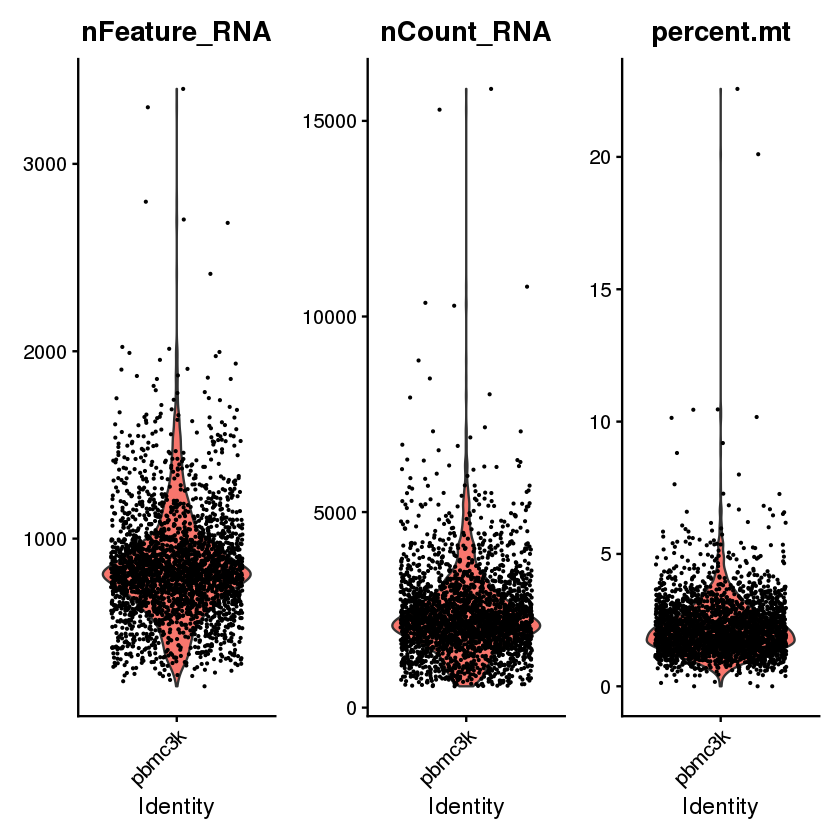

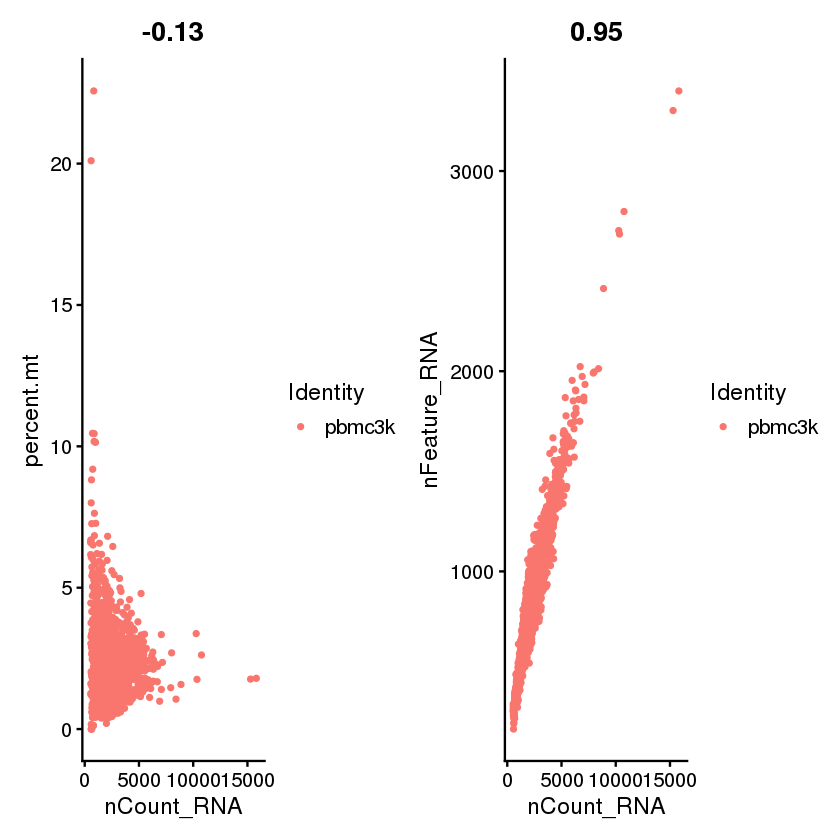

In [7]:

#Visualize QC metrics as a violin plot
VlnPlot(pbmc, features = c("nFeature_RNA", "nCount_RNA", "percent.mt"), ncol = 3)

# FeatureScatter is typically used to visualize feature-feature relationships, but can be used for anything calculated by the object, i.e. columns in object metadata, PC scores etc.

plot1 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "percent.mt") 
plot2 <- FeatureScatter(pbmc, feature1 = "nCount_RNA", feature2 = "nFeature_RNA") 
plot1 + plot2

pbmc <- subset(pbmc, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)

***

# Normalizing the data

After removing unwanted cells from the dataset, the next step is to normalize the data. By default, we employ a global-scaling normalization method "LogNormalize" that normalizes the feature expression measurements for each cell by the total expression, multiplies this by a scale factor (10,000 by default), and log-transforms the result. Normalized values are stored in `pbmc[["RNA"]]@data`.

In [8]:
pbmc <- NormalizeData(pbmc, normalization.method = "LogNormalize", scale.factor = 1e4)

For clarity, in this previous line of code (and in future commands), we provide the default values for certain parameters in the function call. However, this isn't required and the same behavior can be achieved with:

In [9]:
pbmc <- NormalizeData(pbmc)

# Identification of highly variable features (feature selection)

We next calculate a subset of features that exhibit high cell-to-cell variation in the dataset (i.e, they are highly expressed in some cells, and lowly expressed in others). We and [others](https://www.nature.com/articles/nmeth.2645) have found that focusing on these genes in downstream analysis helps to highlight biological signal in single-cell datasets.

Our procedure in Seurat is described in detail [here](https://doi.org/10.1016/j.cell.2019.05.031), and improves on previous versions by directly modeling the mean-variance relationship inherent in single-cell data, and is implemented in the `FindVariableFeatures()` function. By default, we return 2,000 features per dataset. These will be used in downstream analysis, like PCA.

When using repel, set xnudge and ynudge to 0 for optimal results

Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”
Warning message:
“Transformation introduced infinite values in continuous x-axis”
Warning message:
“Removed 1 rows containing missing values (geom_point).”


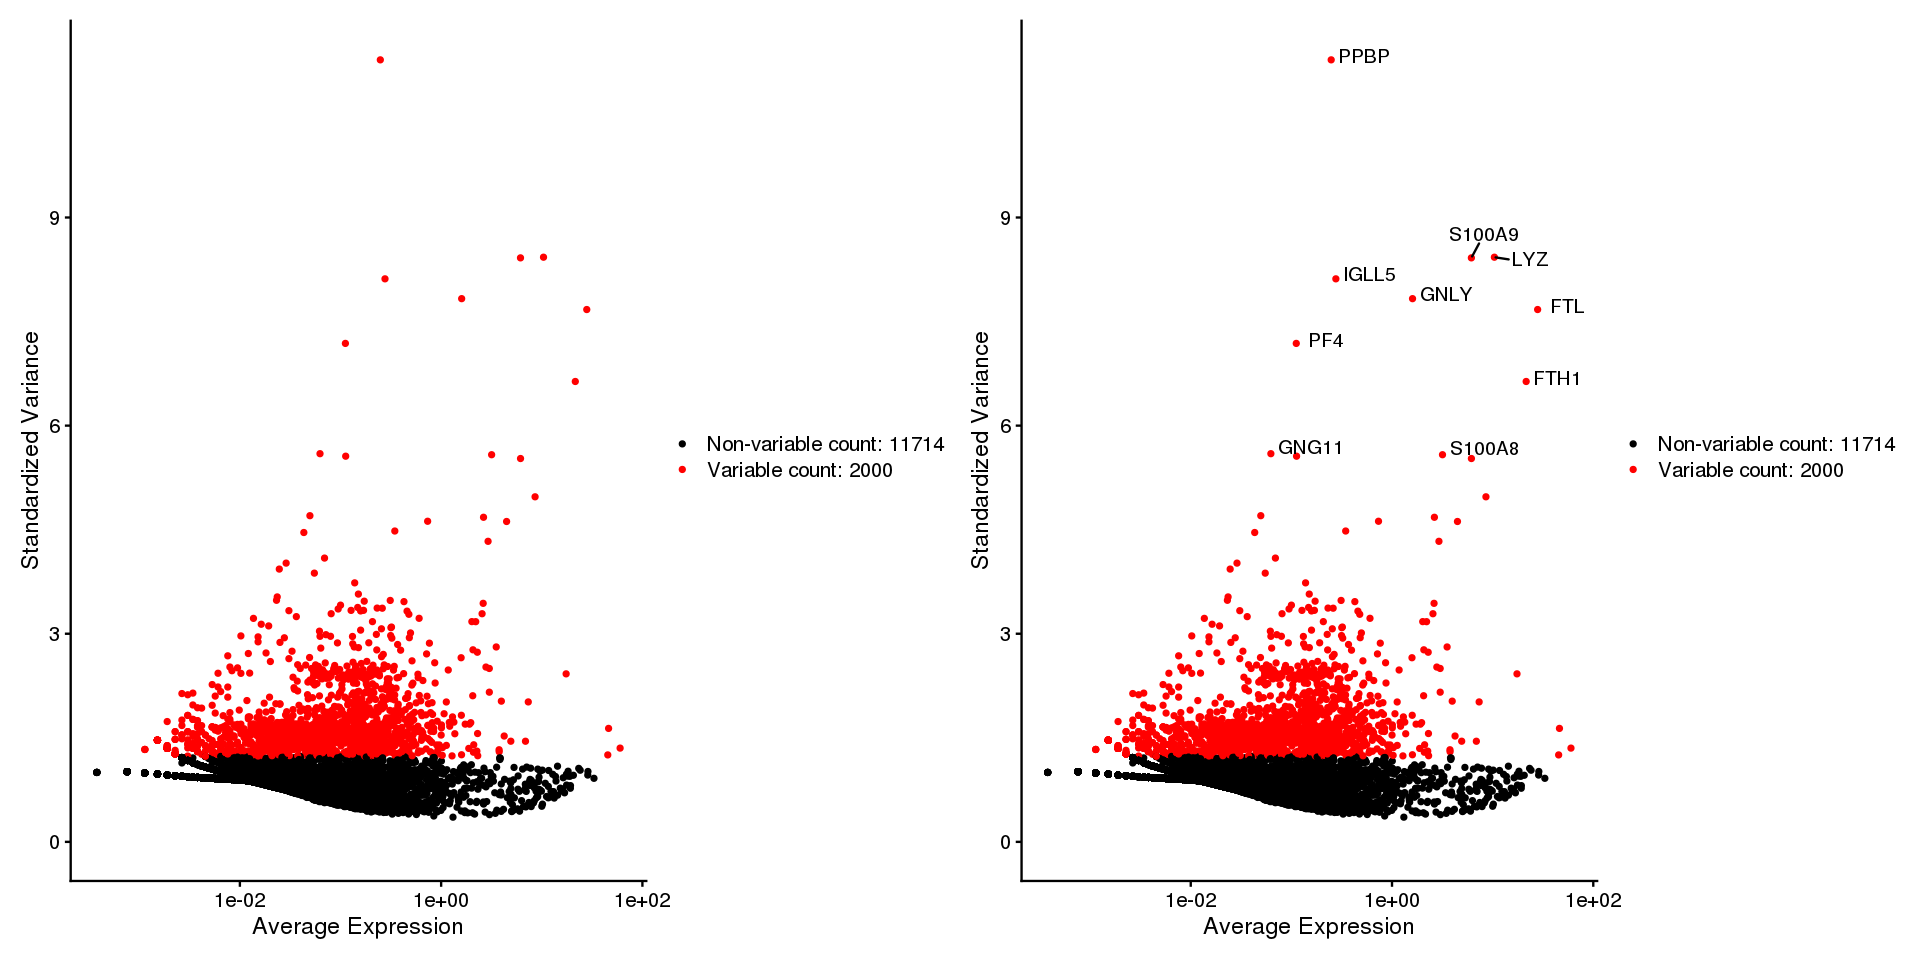

In [11]:
pbmc <- FindVariableFeatures(pbmc, selection.method = 'vst', nfeatures = 2000)

# Identify the 10 most highly variable genes
top10 <- head(VariableFeatures(pbmc), 10)

# plot variable features with and without labels
plot1 <- VariableFeaturePlot(pbmc)
plot2 <- LabelPoints(plot = plot1, points = top10, repel = TRUE)
options(repr.plot.height=8, repr.plot.width=16)

plot1 + plot2

***

# Scaling the data

Next, we apply a linear transformation ('scaling') that is a standard pre-processing step prior to dimensional reduction techniques like PCA. The `ScaleData()` function:

* Shifts the expression of each gene, so that the mean expression across cells is 0
* Scales the expression of each gene, so that the variance across cells is 1
    + This step gives equal weight in downstream analyses, so that highly-expressed genes do not dominate
* The results of this are stored in `pbmc[["RNA"]]@scale.data`

In [12]:
all.genes <- rownames(pbmc)
pbmc <- ScaleData(pbmc, features = all.genes)

Centering and scaling data matrix



<details>
  <summary>**This step takes too long! Can I make it faster?**</summary>

Scaling is an essential step in the Seurat workflow, but only on genes that will be used as input to PCA. Therefore, the default in `ScaleData()` is only to perform scaling on the previously identified variable features (2,000 by default). To do this, omit the `features` argument in the previous function call, i.e.

In [13]:
pbmc <- ScaleData(pbmc)

Centering and scaling data matrix



Your PCA and clustering results will be unaffected. However, Seurat heatmaps (produced as shown below with `DoHeatmap()`) require genes in the heatmap to be scaled, to make sure highly-expressed genes don't dominate the heatmap. To make sure we don't leave any genes out of the heatmap later, we are scaling all genes in this tutorial. 
</details>
\  
<details>
  <summary>**How can I remove unwanted sources of variation, as in Seurat v2?**</summary>

In `Seurat v2` we also use the `ScaleData()` function to remove unwanted sources of variation from a single-cell dataset. For example, we could 'regress out' heterogeneity associated with (for example) cell cycle stage, or mitochondrial contamination. These features are still supported in `ScaleData()` in `Seurat v3`, i.e.: 

In [14]:
pbmc <- ScaleData(pbmc, vars.to.regress = 'percent.mt')

Regressing out percent.mt

Centering and scaling data matrix



However, particularly for advanced users who would like to use this functionality, we strongly recommend the use of our new normalization workflow, `SCTransform()`. The method is described in our [paper](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-019-1874-1), with a separate vignette using Seurat v3 [here](sctransform_vignette.html). As with `ScaleData()`, the function `SCTransform()` also includes a `vars.to.regress` parameter.
</details>
\ 

***

# Perform linear dimensional reduction

Next we perform PCA on the scaled data. By default, only the previously determined variable features are used as input, but can be defined using `features` argument if you wish to choose a different subset.

In [15]:
pbmc <- RunPCA(pbmc, features = VariableFeatures(object = pbmc))

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL, FTH1, LYZ, FCN1, S100A9, TYMP 
	   FCER1G, CFD, LGALS1, LGALS2, SERPINA1, S100A8, CTSS, IFITM3, SPI1, CFP 
	   PSAP, IFI30, COTL1, SAT1, S100A11, NPC2, GRN, LGALS3, GSTP1, PYCARD 
Negative:  MALAT1, LTB, IL32, IL7R, CD2, B2M, ACAP1, CTSW, STK17A, CD27 
	   CD247, CCL5, GIMAP5, GZMA, AQP3, CST7, TRAF3IP3, SELL, GZMK, HOPX 
	   MAL, MYC, ITM2A, ETS1, LYAR, GIMAP7, KLRG1, NKG7, ZAP70, BEX2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1, HLA-DRA, LINC00926, CD79B, HLA-DRB1, CD74 
	   HLA-DMA, HLA-DPB1, HLA-DQA2, CD37, HLA-DRB5, HLA-DMB, HLA-DPA1, FCRLA, HVCN1, LTB 
	   BLNK, P2RX5, IGLL5, IRF8, SWAP70, ARHGAP24, FCGR2B, SMIM14, PPP1R14A, C16orf74 
Negative:  NKG7, PRF1, CST7, GZMA, GZMB, FGFBP2, CTSW, GNLY, B2M, SPON2 
	   CCL4, GZMH, FCGR3A, CCL5, CD247, XCL2, CLIC3, AKR1C3, SRGN, HOPX 
	   TTC38, CTSC, APMAP, S100A4, IGFBP7, ANXA1, ID2, IL32, XCL1, RHOC 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPA1, HLA-DPB1, CD

Seurat provides several useful ways of visualizing both cells and features that define the PCA, including `VizDimReduction()`, `DimPlot()`, and `DimHeatmap()`

PC_ 1 
Positive:  CST3, TYROBP, LST1, AIF1, FTL 
Negative:  MALAT1, LTB, IL32, IL7R, CD2 
PC_ 2 
Positive:  CD79A, MS4A1, TCL1A, HLA-DQA1, HLA-DQB1 
Negative:  NKG7, PRF1, CST7, GZMA, GZMB 
PC_ 3 
Positive:  HLA-DQA1, CD79A, CD79B, HLA-DQB1, HLA-DPA1 
Negative:  PPBP, PF4, SDPR, SPARC, GNG11 
PC_ 4 
Positive:  HLA-DQA1, CD79B, CD79A, MS4A1, HLA-DQB1 
Negative:  VIM, IL7R, S100A6, S100A8, IL32 
PC_ 5 
Positive:  GZMB, FGFBP2, S100A8, NKG7, GNLY 
Negative:  LTB, IL7R, CKB, MS4A7, RP11-290F20.3 


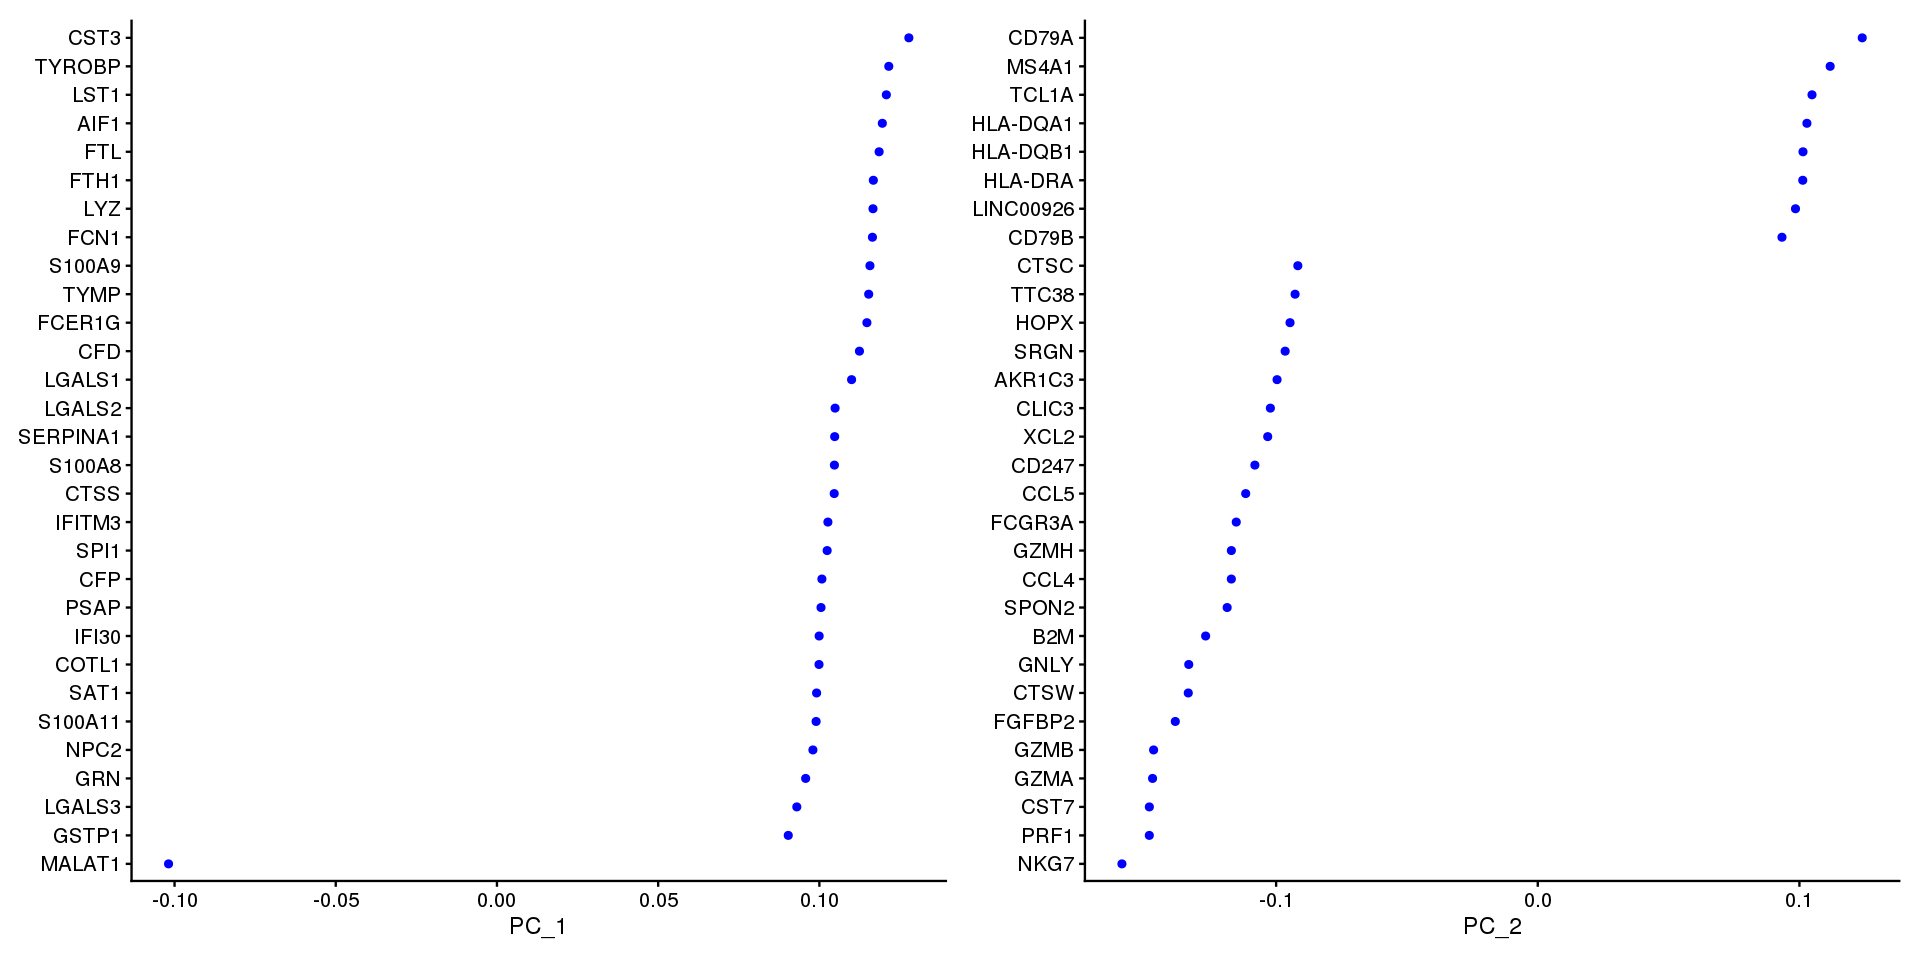

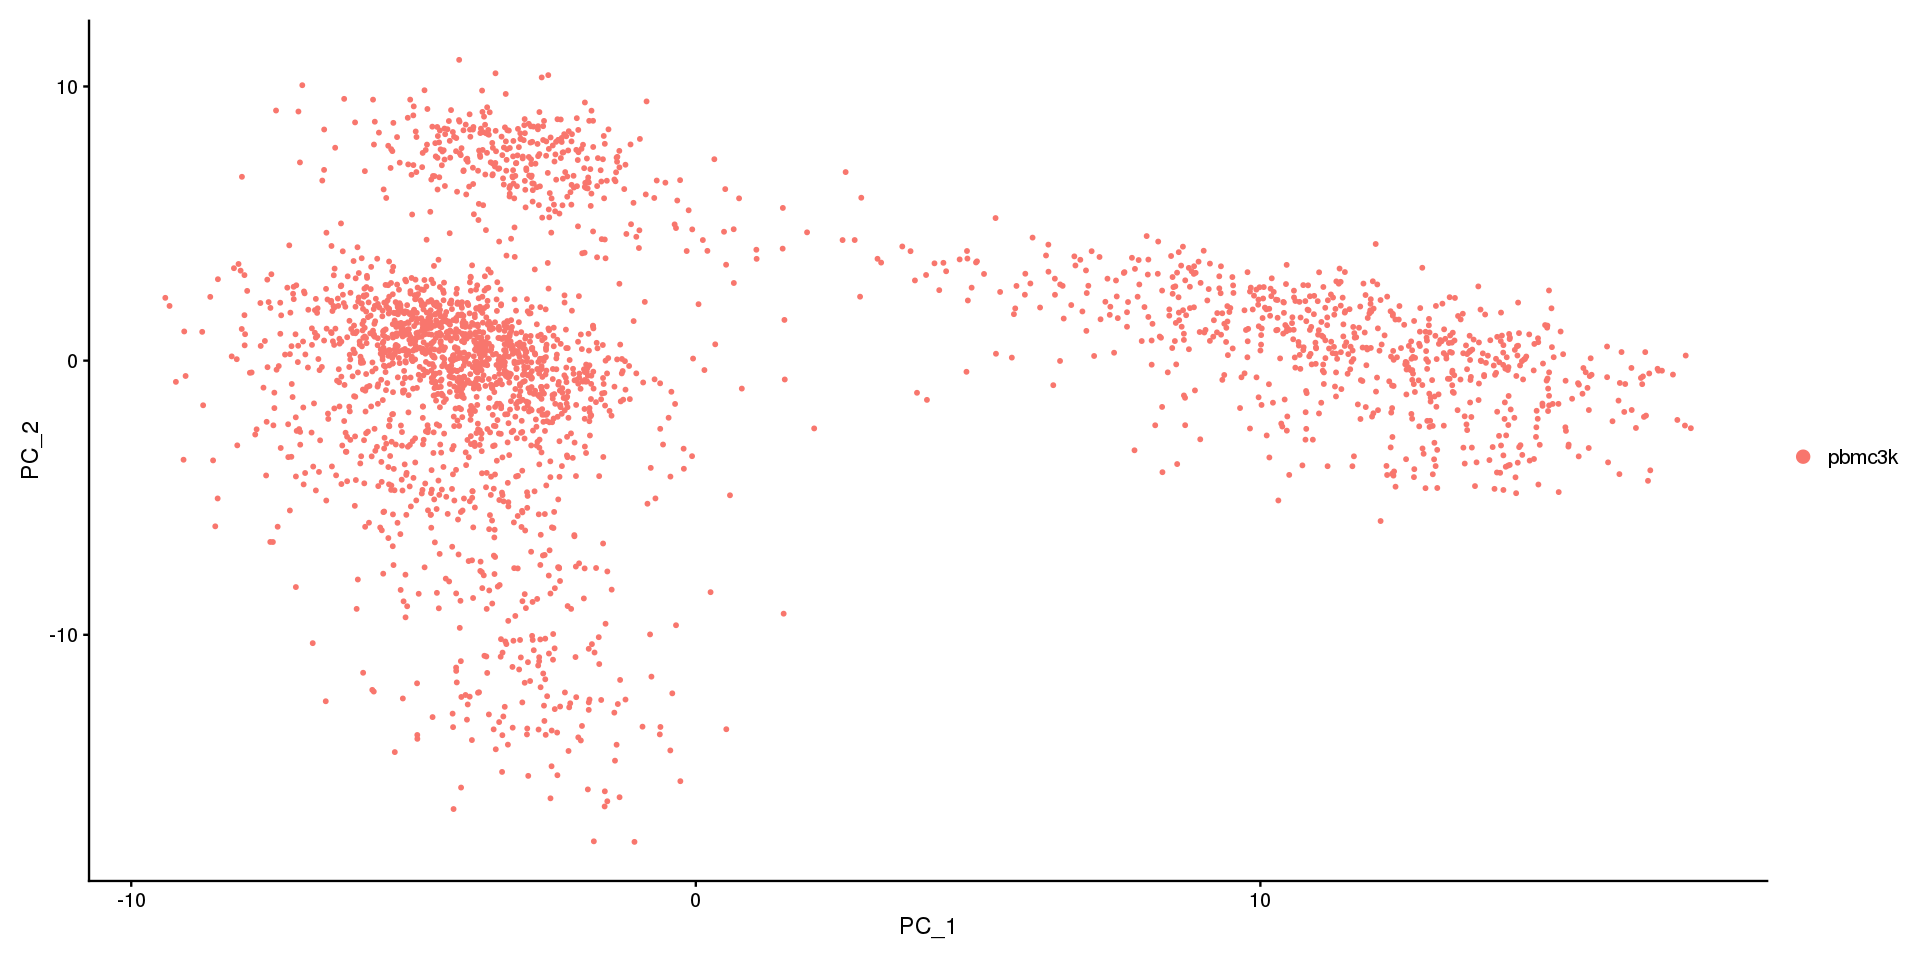

In [16]:
# Examine and visualize PCA results a few different ways
print(pbmc[['pca']], dims = 1:5, nfeatures = 5)
VizDimLoadings(pbmc, dims = 1:2, reduction = 'pca')
DimPlot(pbmc, reduction = 'pca')

In particular `DimHeatmap()` allows for easy exploration of the primary sources of heterogeneity in a dataset, and can be useful when trying to decide which PCs to include for further downstream analyses. Both cells and features are ordered according to their PCA scores. Setting `cells` to a number plots the 'extreme' cells on both ends of the spectrum, which dramatically speeds plotting for large datasets. Though clearly a supervised analysis, we find this to be a valuable tool for exploring correlated feature sets.

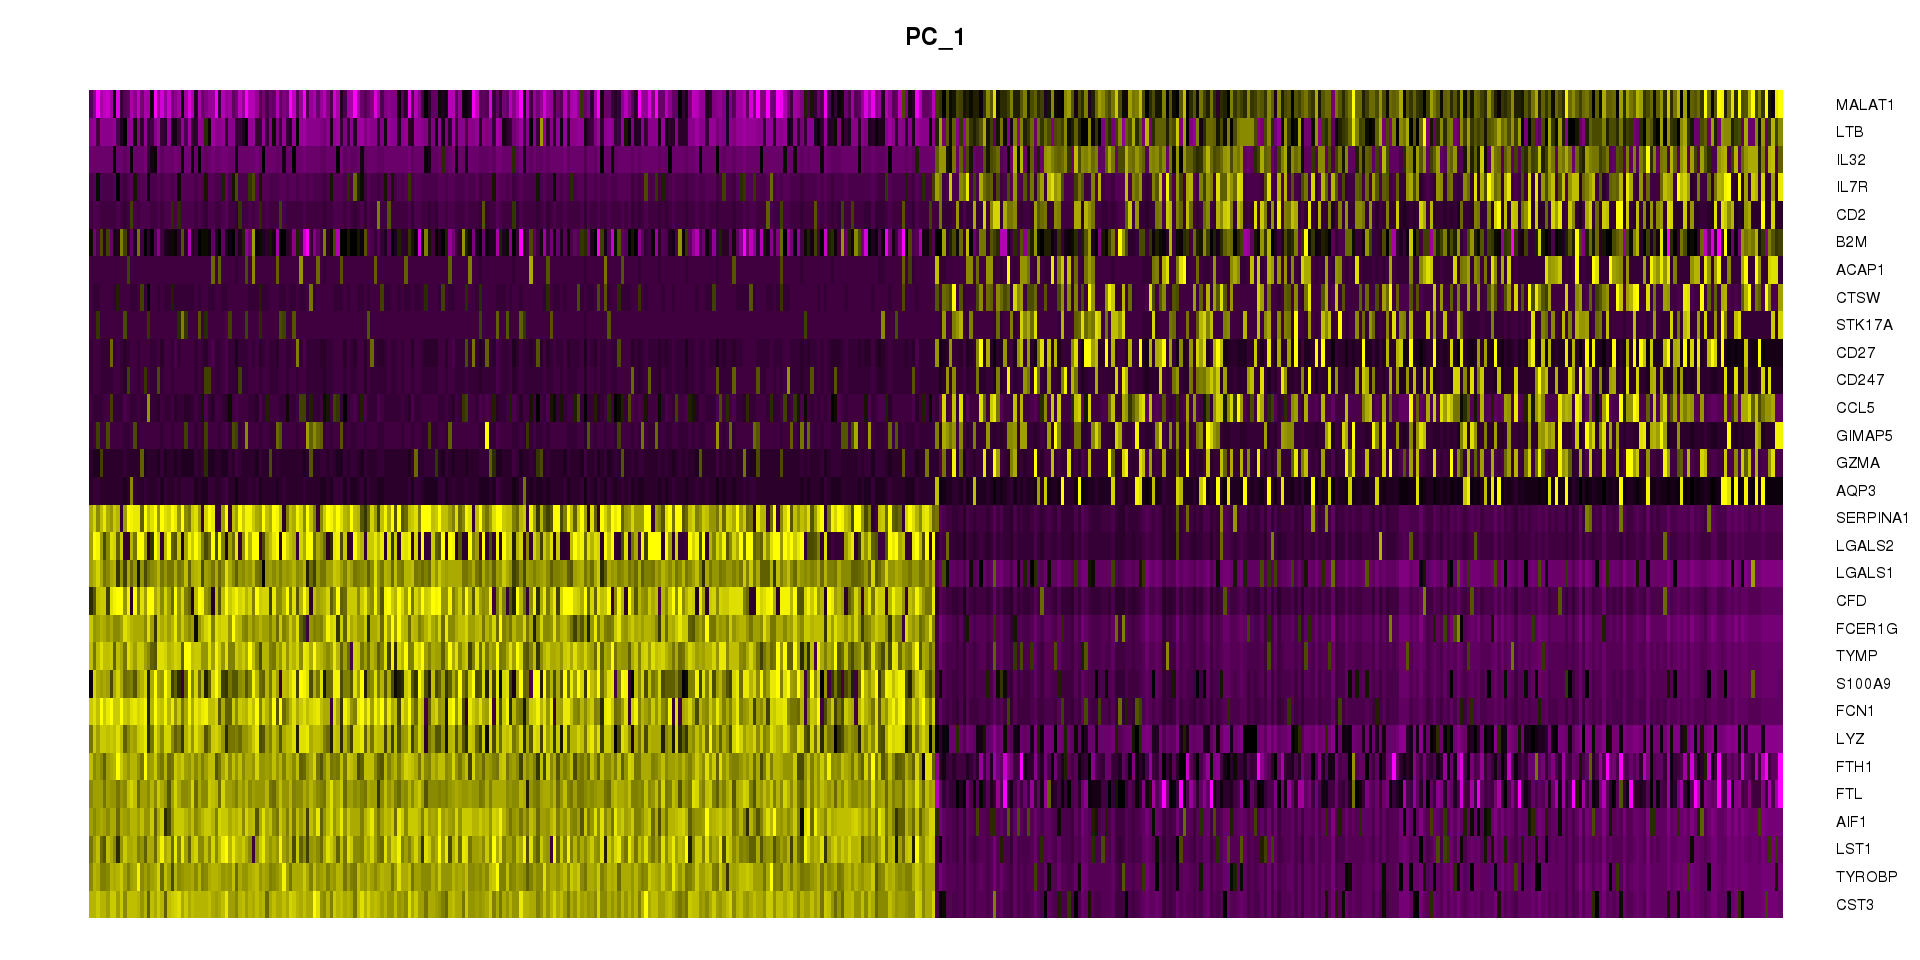

In [17]:
DimHeatmap(pbmc, dims = 1, cells = 500, balanced = TRUE)

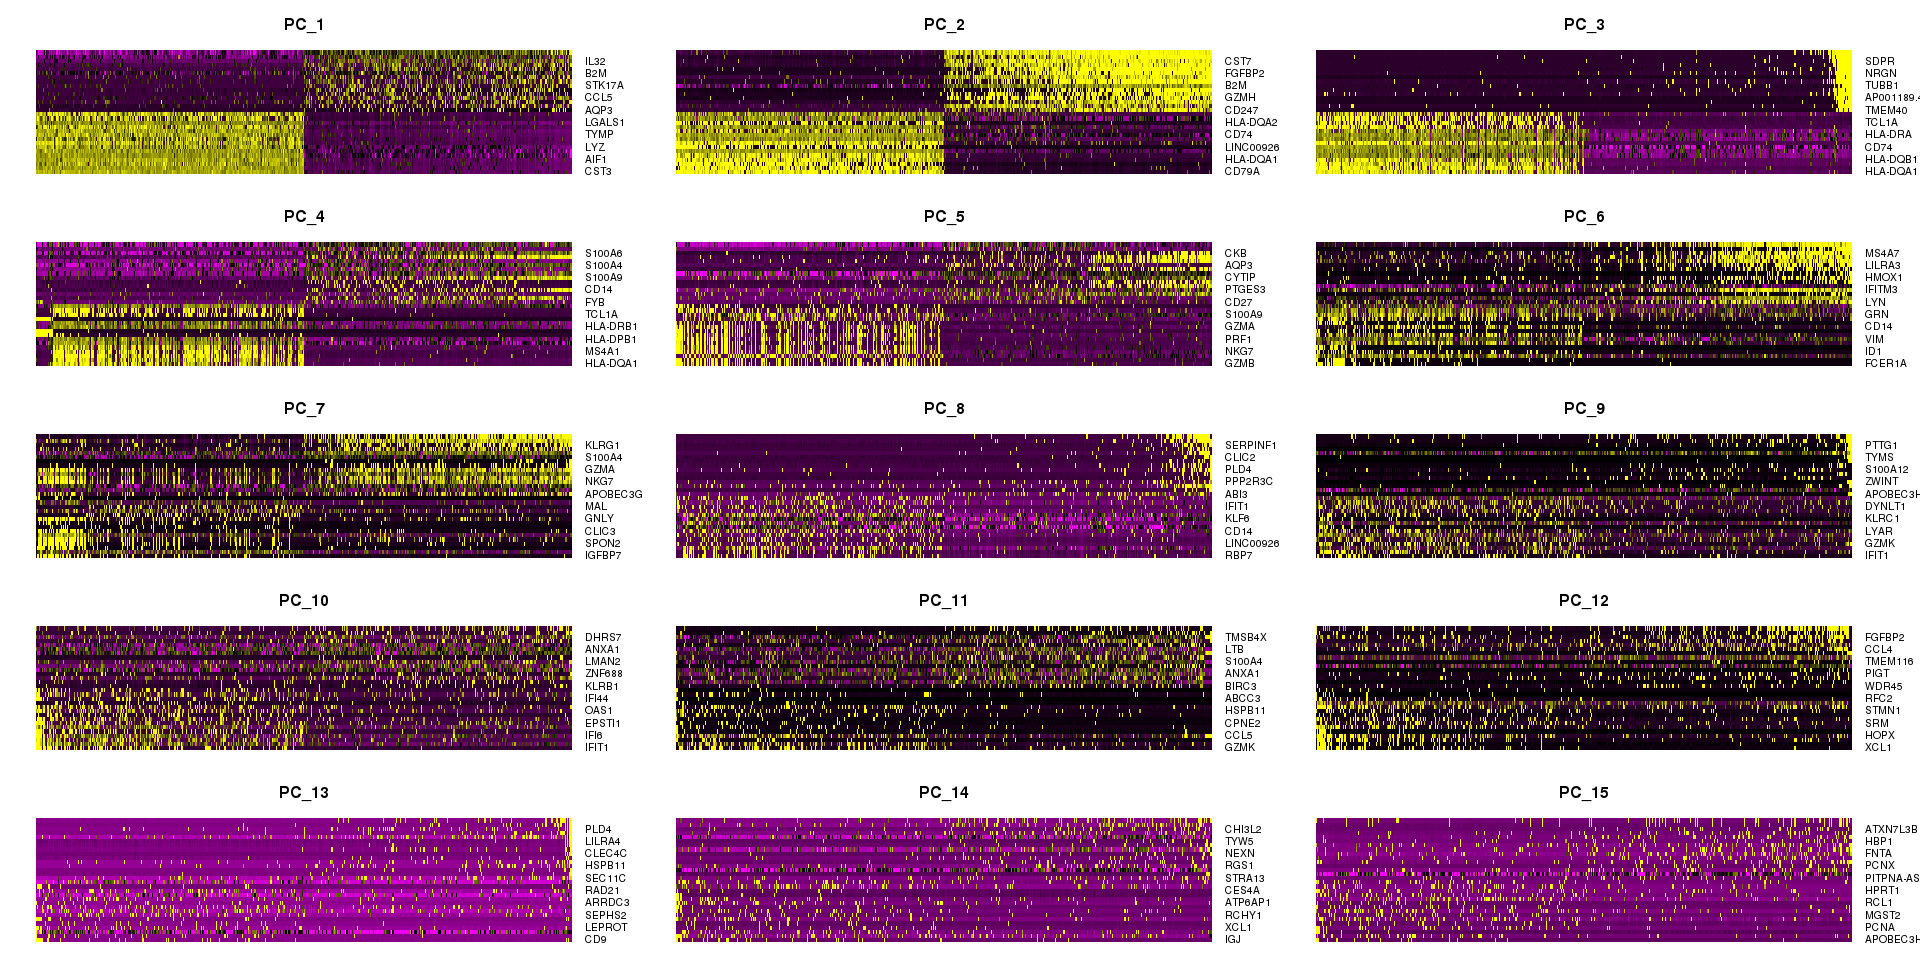

In [18]:
DimHeatmap(pbmc, dims = 1:15, cells = 500, balanced = TRUE)

# Determine the 'dimensionality' of the dataset

To overcome the extensive technical noise in any single feature for scRNA-seq data, Seurat clusters cells based on their PCA scores, with each PC essentially representing a 'metafeature' that combines information across a correlated feature set. The top principal components therefore represent a robust compression of the dataset. However, how many components should we choose to include? 10? 20? 100?

In [Macosko *et al*](http://www.cell.com/abstract/S0092-8674(15)00549-8), we implemented a resampling test inspired by the JackStraw procedure. We randomly permute a subset of the data (1% by default) and rerun PCA, constructing a 'null distribution' of feature scores, and repeat this procedure. We identify 'significant' PCs as those who have a strong enrichment of low p-value features.

In [20]:
# 3:26-3:32

In [19]:
# NOTE: This process can take a long time for big datasets, comment out for expediency. More approximate techniques such as those implemented in ElbowPlot() can be used to reduce computation time
pbmc <- JackStraw(pbmc, num.replicate = 100)
pbmc <- ScoreJackStraw(pbmc, dims = 1:20)

The `JackStrawPlot()` function provides a visualization tool for comparing the distribution of p-values for each PC with a uniform distribution (dashed line). 'Significant' PCs will show a strong enrichment of features with low p-values (solid curve above the dashed line). In this case it appears that there is a sharp drop-off in significance after the first 10-12 PCs.

Warning message:
“Removed 23432 rows containing missing values (geom_point).”


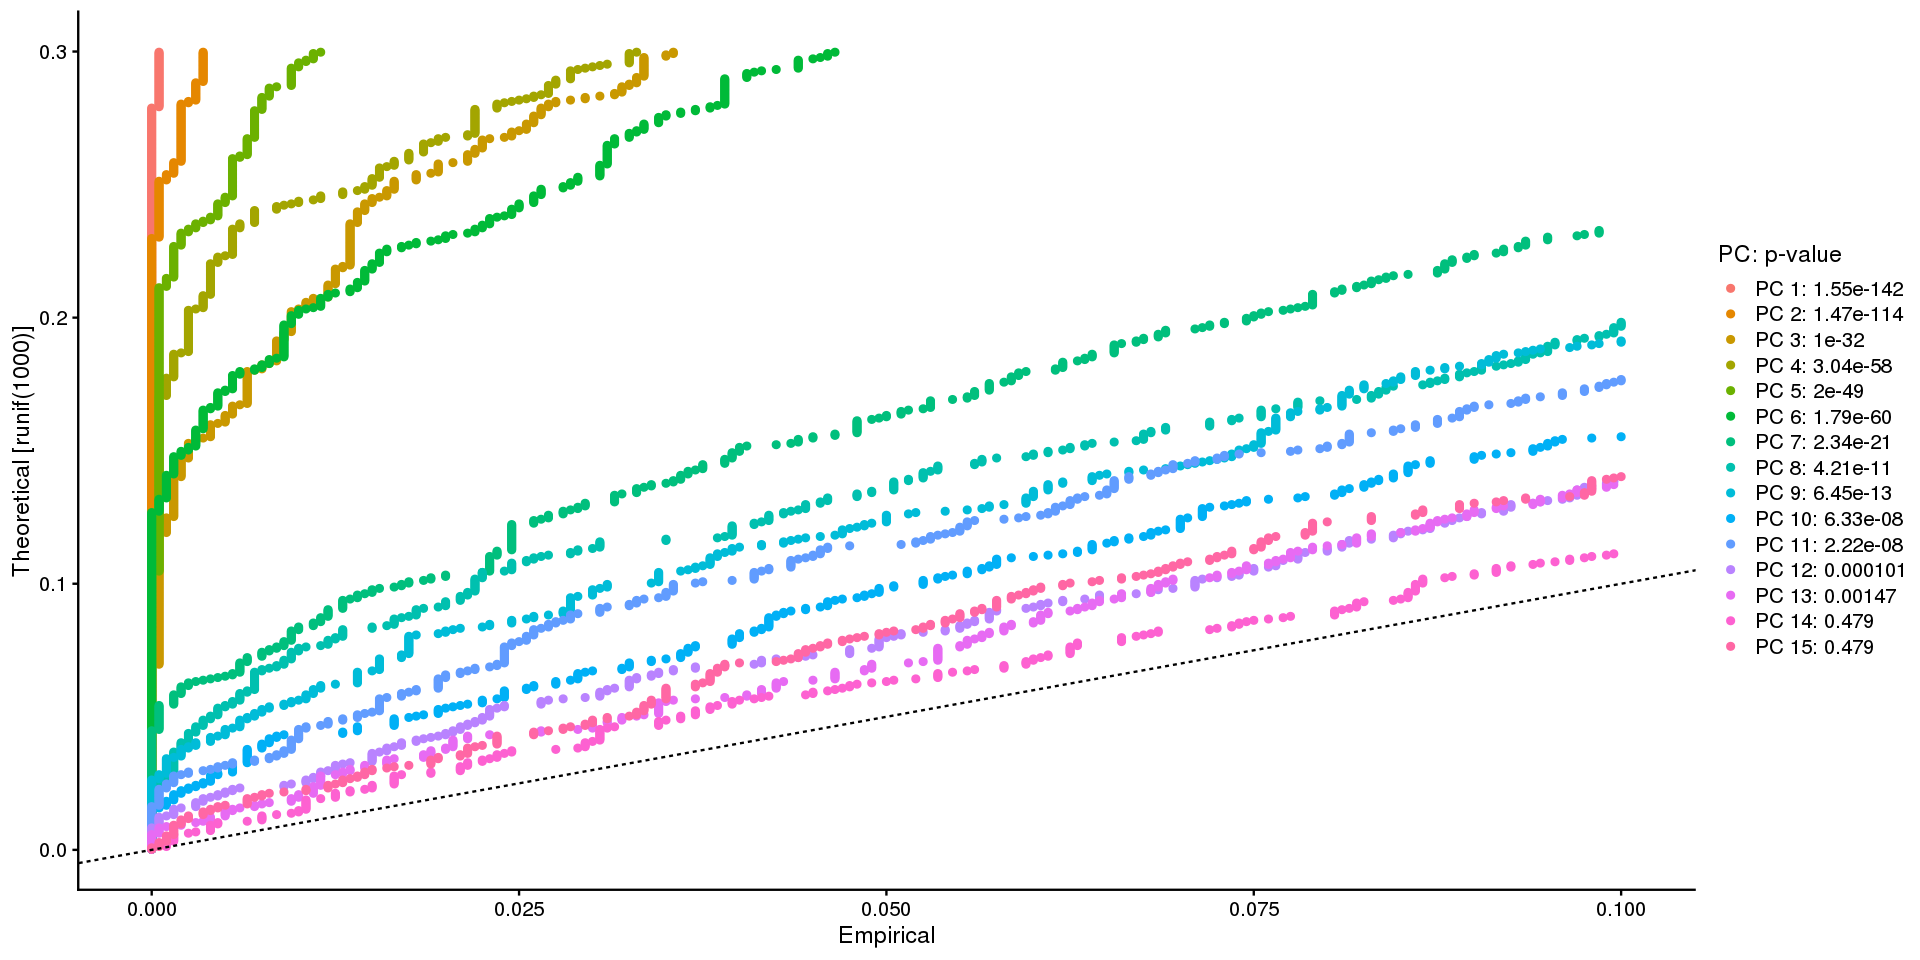

In [21]:
JackStrawPlot(pbmc, dims = 1:15)

An alternative heuristic method generates an 'Elbow plot': a ranking of principle components based on the percentage of variance explained by each one (`ElbowPlot()` function). In this example, we can observe an 'elbow' around PC9-10, suggesting that the majority of true signal is captured in the first 10 PCs. 

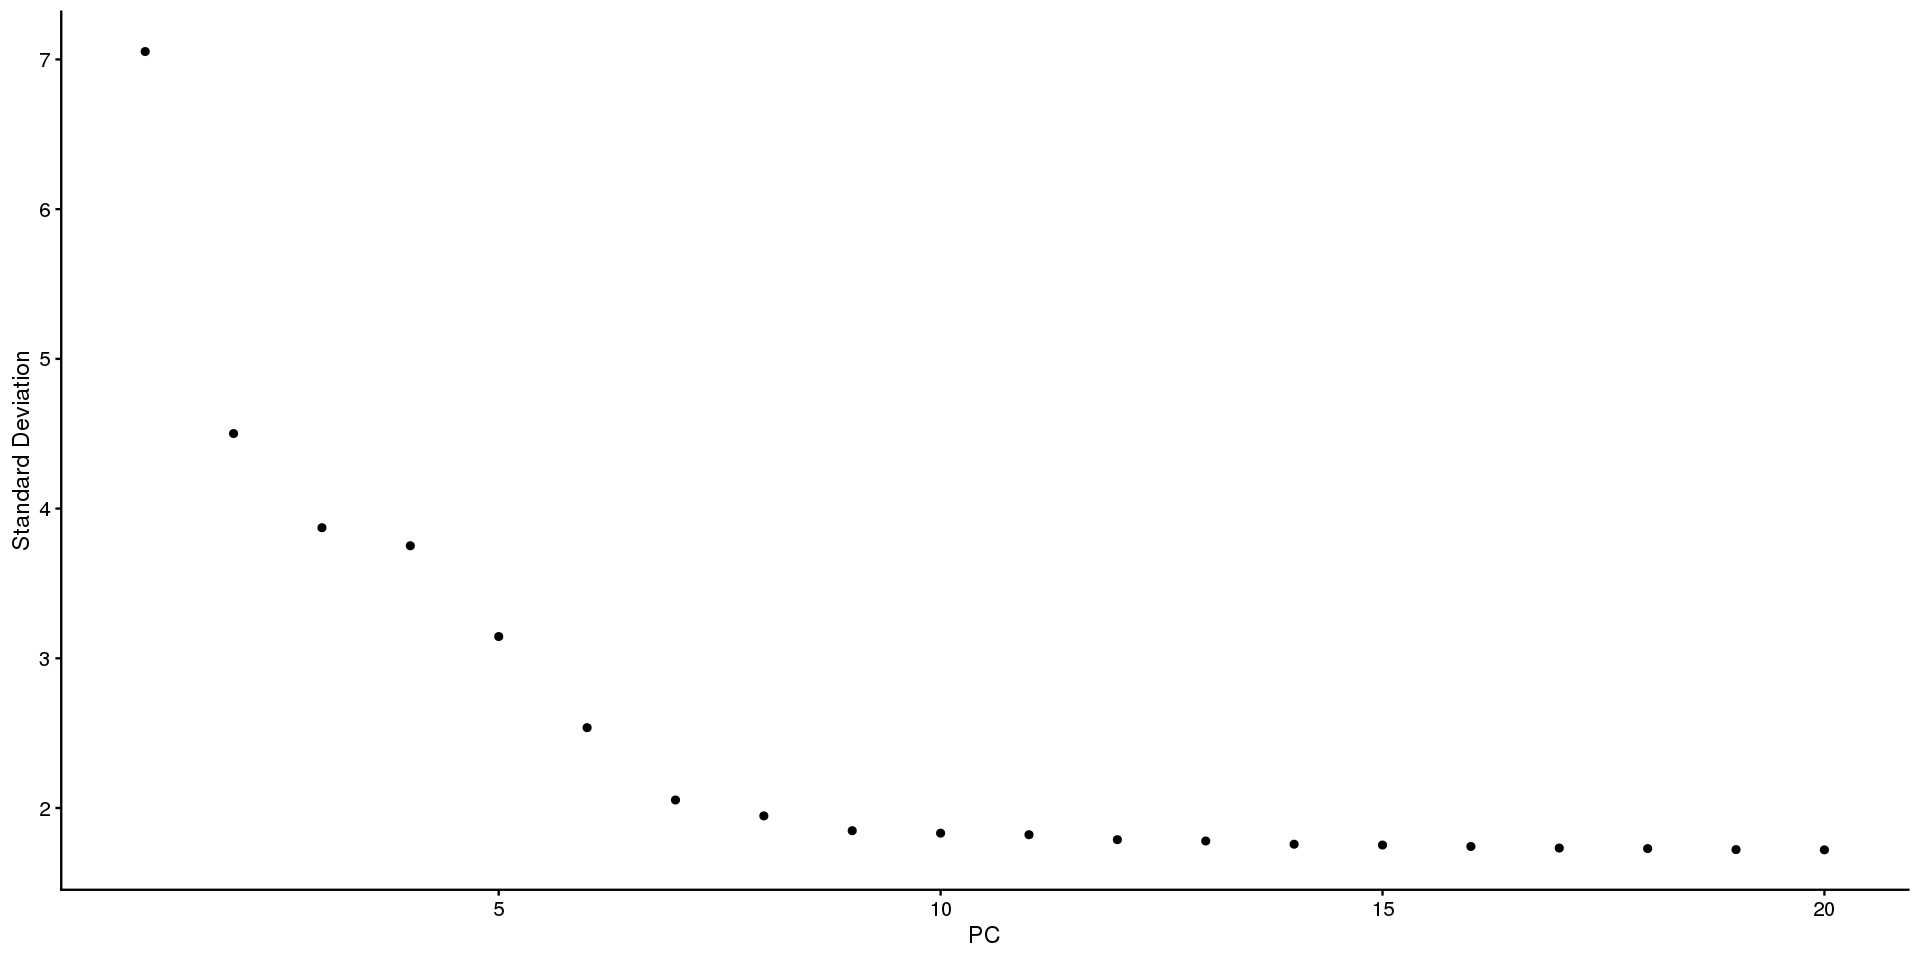

In [22]:
ElbowPlot(pbmc)

Identifying the true dimensionality of a dataset -- can be challenging/uncertain for the user. We therefore suggest these three approaches to consider. The first is more supervised, exploring PCs to determine relevant sources of heterogeneity, and could be used in conjunction with GSEA for example. The second implements a statistical test based on a random null model, but is time-consuming for large datasets, and may not return a clear PC cutoff. The third is a heuristic that is commonly used, and can be calculated instantly. In this example, all three approaches yielded similar results, but we might have been justified in choosing anything between PC 7-12 as a cutoff. 

We chose 10 here, but encourage users to consider the following:

* Dendritic cell and NK aficionados may recognize that genes strongly associated with PCs 12 and 13 define rare immune subsets (i.e. MZB1 is a marker for plasmacytoid DCs). However, these groups are so rare, they are difficult to distinguish from background noise for a dataset of this size without prior knowledge. 
* We encourage users to repeat downstream analyses with a different number of PCs (10, 15, or even 50!). As you will observe, the results often do not differ dramatically.
* We advise users to err on the higher side when choosing this parameter. For example, performing downstream analyses with only 5 PCs does significantly and adversely affect results.

***

# Cluster the cells

Seurat v3 applies a graph-based clustering approach, building upon initial strategies in ([Macosko *et al*](http://www.cell.com/abstract/S0092-8674(15)00549-8)). Importantly, the *distance metric* which drives the clustering analysis (based on previously identified PCs) remains the same. However, our approach to partitioning the cellular distance matrix into clusters has dramatically improved. Our approach was heavily inspired by recent manuscripts which applied graph-based clustering approaches to scRNA-seq data [[SNN-Cliq, Xu and Su, Bioinformatics, 2015]](http://bioinformatics.oxfordjournals.org/content/early/2015/02/10/bioinformatics.btv088.abstract) and CyTOF data [[PhenoGraph, Levine *et al*., Cell, 2015]](http://www.ncbi.nlm.nih.gov/pubmed/26095251). Briefly, these methods embed cells in a graph structure - for example a K-nearest neighbor (KNN) graph, with edges drawn between cells with similar feature expression patterns, and then attempt to partition this graph into highly interconnected 'quasi-cliques' or 'communities'. 

As in PhenoGraph, we first construct a KNN graph based on the euclidean distance in PCA space, and refine the edge weights between any two cells based on the shared overlap in their local neighborhoods (Jaccard similarity). This step is performed using the `FindNeighbors()` function, and takes as input the previously defined dimensionality of the dataset (first 10 PCs).

To cluster the cells, we next apply modularity optimization techniques such as the Louvain algorithm (default) or SLM [[SLM, Blondel *et al*., Journal of Statistical Mechanics]](http://dx.doi.org/10.1088/1742-5468/2008/10/P10008), to iteratively group cells together, with the goal of optimizing the standard modularity function. The `FindClusters()` function implements this procedure, and contains a resolution parameter that sets the 'granularity' of the downstream clustering, with increased values leading to a greater number of clusters. We find that setting this parameter between 0.4-1.2 typically returns good results for single-cell datasets of around 3K cells. Optimal resolution often increases for larger datasets. The clusters can be found using the `Idents()` function.


In [23]:
pbmc <- FindNeighbors(pbmc, dims = 1:10)
pbmc <- FindClusters(pbmc, resolution = 0.5)

# Look at cluster IDs of the first 5 cells
head(Idents(pbmc), 5)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2638
Number of edges: 95905

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8735
Number of communities: 9
Elapsed time: 0 seconds


AAACATACAACCAC-1 AAACATTGAGCTAC-1 AAACATTGATCAGC-1 AAACCGTGCTTCCG-1 
               0                3                2                1 
AAACCGTGTATGCG-1 
               6 
Levels: 0 1 2 3 4 5 6 7 8

***

# Run non-linear dimensional reduction (UMAP/tSNE)

Seurat offers several non-linear dimensional reduction techniques, such as tSNE and UMAP, to visualize and explore these datasets. The goal of these algorithms is to learn the underlying manifold of the data in order to place similar cells together in low-dimensional space. Cells within the graph-based clusters determined above should co-localize on these dimension reduction plots. As input to the UMAP and tSNE, we suggest using the same PCs as input to the clustering analysis.

In [ ]:
# 3:34-3;34

In [24]:
# If you haven't installed UMAP, you can do so via reticulate::py_install(packages = "umap-learn")
pbmc <- RunUMAP(pbmc, dims = 1:10)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
15:33:45 UMAP embedding parameters a = 0.9922 b = 1.112

15:33:45 Read 2638 rows and found 10 numeric columns

15:33:45 Using Annoy for neighbor search, n_neighbors = 30

15:33:45 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

15:33:45 Writing NN index file to temp file /lscratch/17559021/RtmpgZaLrr/file54922647b827

15:33:45 Searching Annoy index using 1 thread, search_k = 3000

15:33:47 Annoy recall = 100%

15:33:47 Commencing smooth kNN distance calibration using 1 thread

15:33:47 In

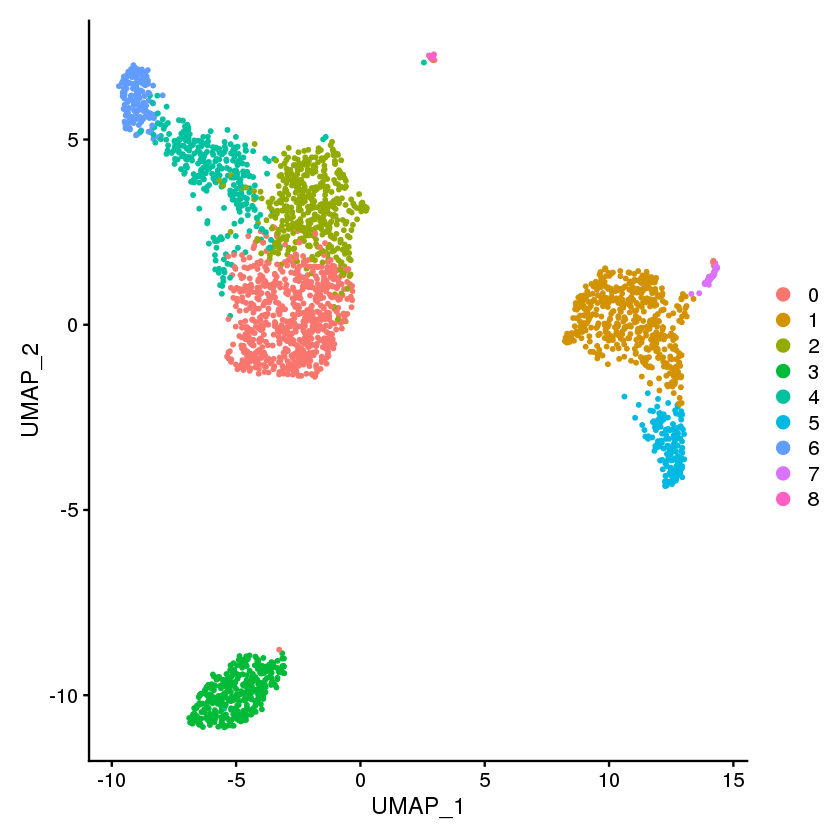

In [28]:
# note that you can set `label = TRUE` or use the LabelClusters function to help label individual clusters
DimPlot(pbmc, reduction = 'umap')

You can save the object at this point so that it can easily be loaded back in without having to rerun the computationally intensive steps performed above, or easily shared with collaborators.

In [30]:
saveRDS(pbmc, file = "../output/pbmc_tutorial.rds")

***

# Finding differentially expressed features (cluster biomarkers)

Seurat can help you find markers that define clusters via differential expression. By default, it identifies positive and negative markers of a single cluster (specified in `ident.1`), compared to all other cells.  `FindAllMarkers()` automates this process for all clusters, but you can also test groups of clusters vs. each other, or against all cells.

The `min.pct` argument requires a feature to be detected at a minimum percentage in either of the two groups of cells, and the thresh.test argument requires a feature to be differentially expressed (on average) by some amount between the two groups. You can set both of these to 0, but with a dramatic increase in time - since this will test a large number of features that are unlikely to be highly discriminatory. As another option to speed up these computations, `max.cells.per.ident` can be set. This will downsample each identity class to have no more cells than whatever this is set to. While there is generally going to be a loss in power, the speed increases can be significant and the most highly differentially expressed features will likely still rise to the top.

In [25]:
# find all markers of cluster 2
cluster2.markers <- FindMarkers(pbmc, ident.1 = 2, min.pct = 0.25)
head(cluster2.markers, n = 5)
# find all markers distinguishing cluster 5 from clusters 0 and 3
cluster5.markers <- FindMarkers(pbmc, ident.1 = 5, ident.2 = c(0, 3), min.pct = 0.25)
head(cluster5.markers, n = 5)
# find markers for every cluster compared to all remaining cells, report only the positive ones
pbmc.markers <- FindAllMarkers(pbmc, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
pbmc.markers %>% group_by(cluster) %>% top_n(n = 2, wt = avg_log2FC)

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
LTB,1.709675e-83,1.2693184,0.982,0.647,2.344648e-79
IL32,5.076510e-83,1.1430374,0.947,0.471,6.961926e-79
LDHB,2.467055e-68,0.9468006,0.967,0.615,3.383320e-64
CD3D,1.817480e-66,0.9389006,0.920,0.438,2.492492e-62
IL7R,8.698894e-61,1.1497893,0.744,0.333,1.192966e-56


,p_val,avg_log2FC,pct.1,pct.2,p_val_adj
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
FCGR3A,5.972471e-204,4.279552,0.975,0.041,8.190647e-200
IFITM3,5.671364e-195,3.880994,0.975,0.048,7.777708e-191
CFD,2.389538e-193,3.413418,0.937,0.038,3.277012e-189
CD68,1.800066e-189,3.017072,0.925,0.036,2.468611e-185
RP11-290F20.3,6.852416e-189,2.734400,0.843,0.015,9.397404e-185


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8



p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
5.315619e-114,1.067017,0.912,0.591,7.289840e-110,0,LDHB
1.305705e-83,1.331833,0.439,0.110,1.790644e-79,0,CCR7
0.000000e+00,5.576936,0.996,0.214,0.000000e+00,1,S100A9
0.000000e+00,5.481218,0.973,0.121,0.000000e+00,1,S100A8
1.709675e-83,1.269318,0.982,0.647,2.344648e-79,2,LTB
1.773723e-58,1.254719,0.659,0.249,2.432484e-54,2,CD2
0.000000e+00,4.314919,0.939,0.042,0.000000e+00,3,CD79A
1.055671e-269,3.586567,0.623,0.022,1.447748e-265,3,TCL1A
5.982460e-221,3.212235,0.987,0.226,8.204346e-217,4,CCL5


Seurat has several tests for differential expression which can be set with the test.use parameter (see our [DE vignette](de_vignette.html) for details). For example, the ROC test returns the 'classification power' for any individual marker (ranging from 0 - random, to 1 - perfect).

In [26]:
cluster0.markers <- FindMarkers(pbmc, ident.1 = 0, logfc.threshold = 0.25, test.use = "roc", only.pos = TRUE)

We include several tools for visualizing marker expression. `VlnPlot()` (shows expression probability distributions across clusters), and `FeaturePlot()` (visualizes feature expression on a tSNE or PCA plot) are our most commonly used visualizations. We also suggest exploring `RidgePlot()`, `CellScatter()`, and `DotPlot()` as additional methods to view your dataset.

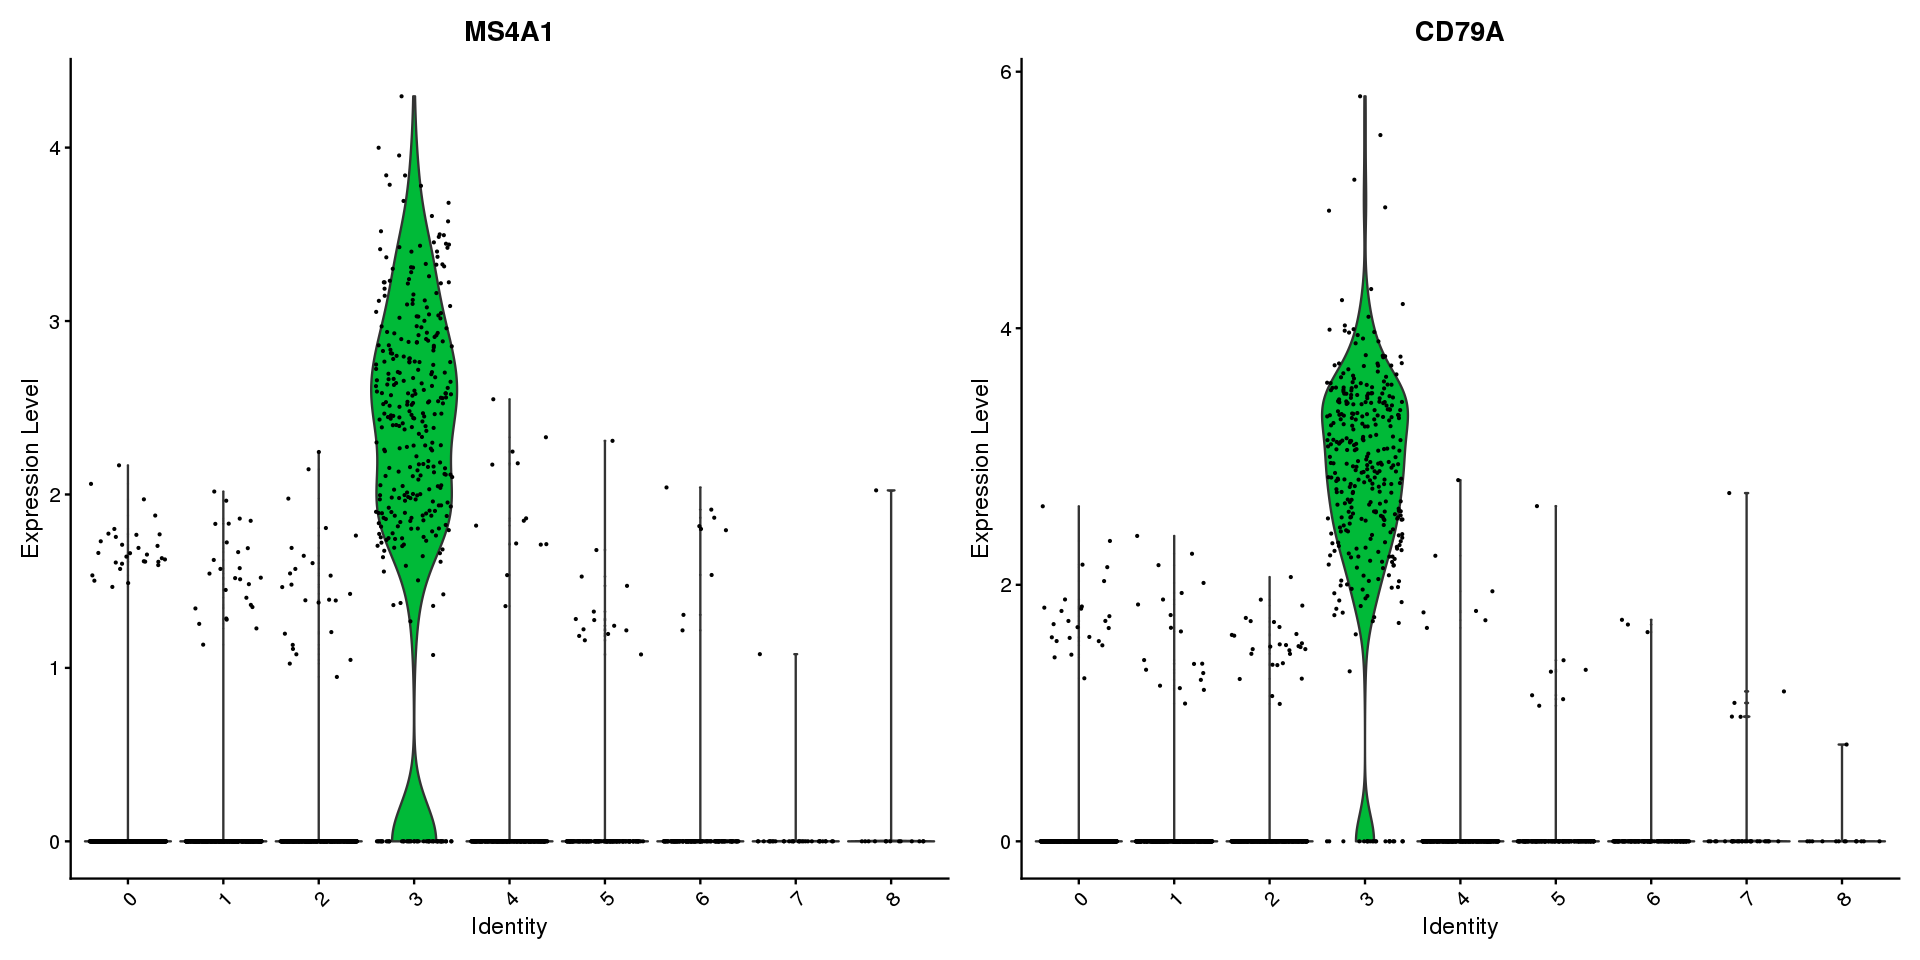

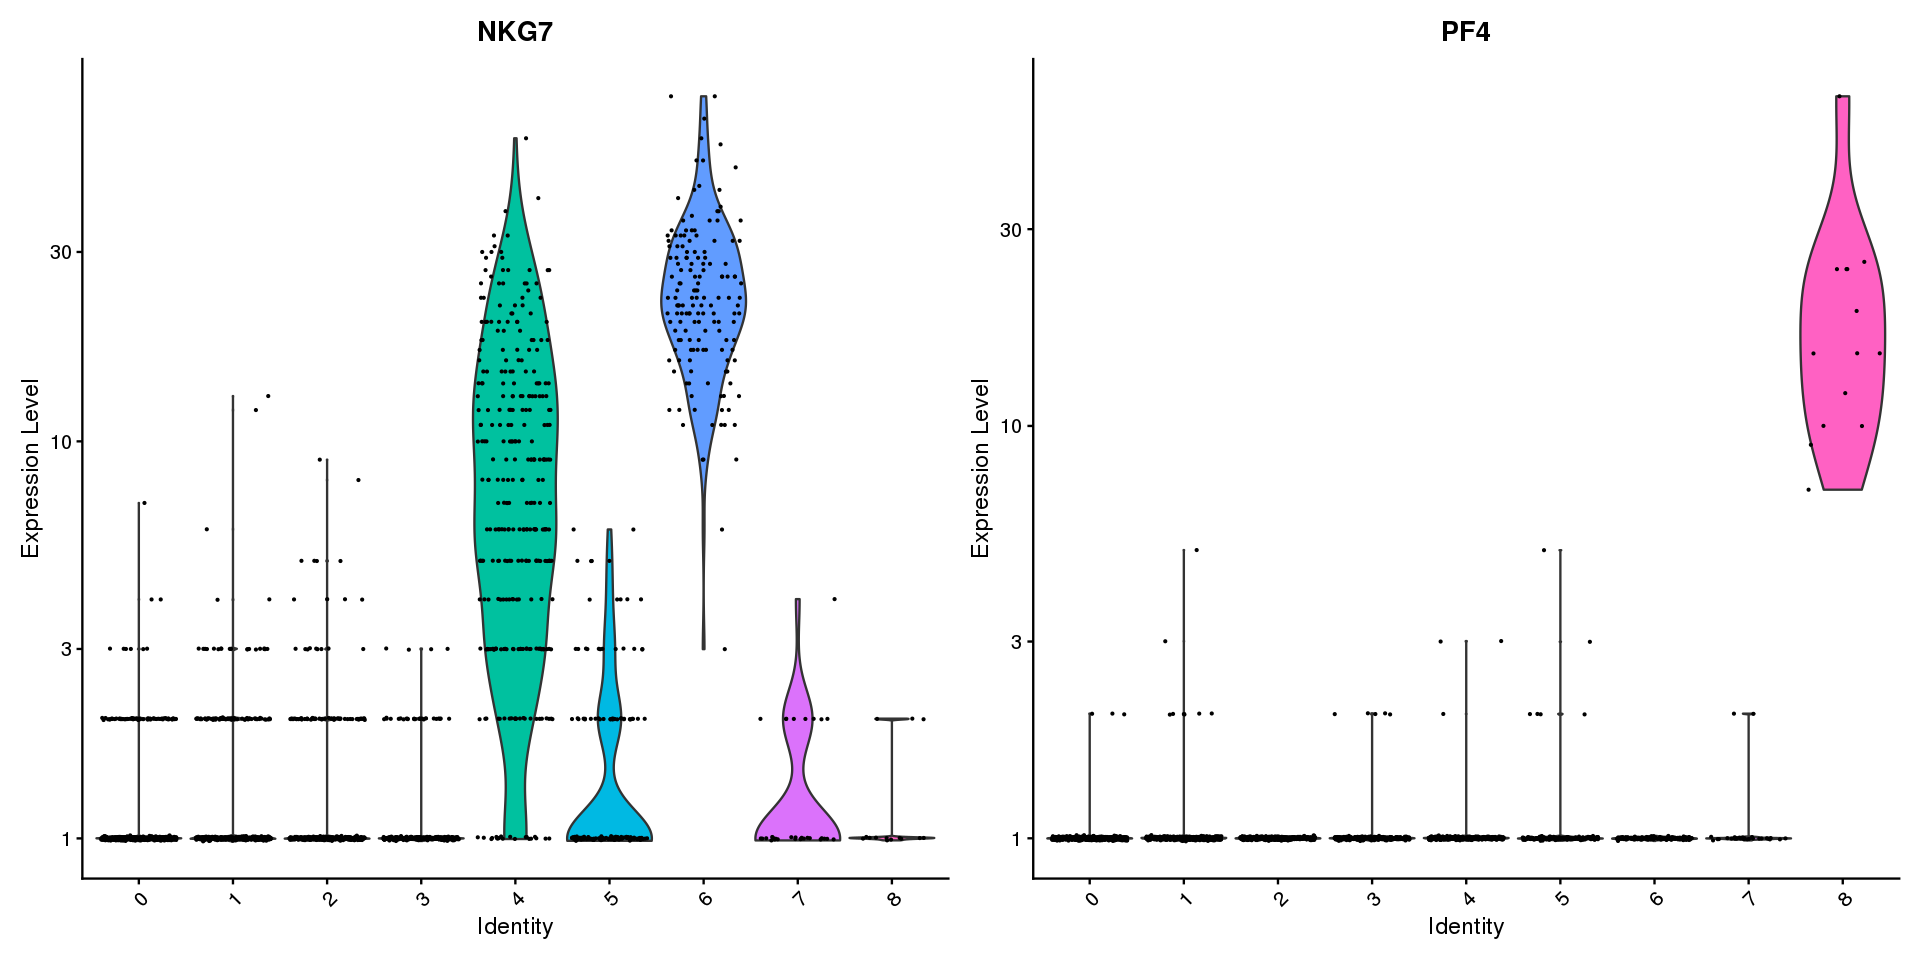

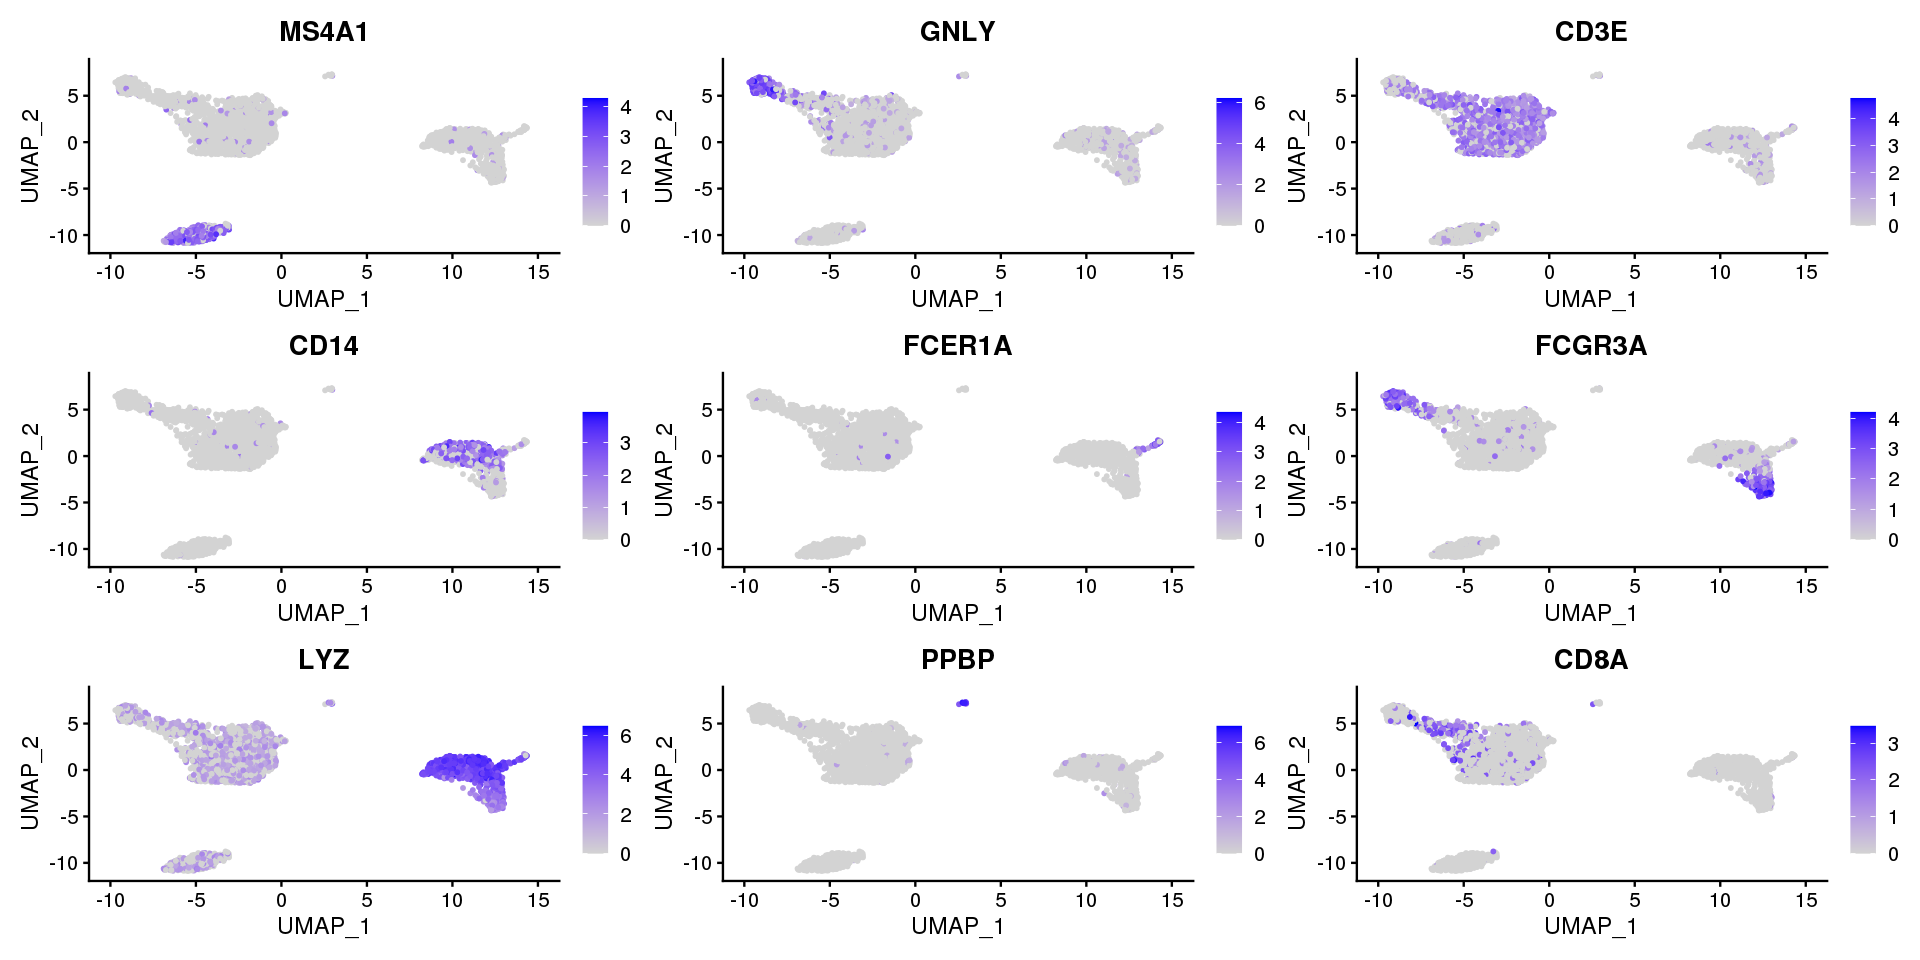

In [27]:
VlnPlot(pbmc, features = c("MS4A1", "CD79A"))
# you can plot raw counts as well
VlnPlot(pbmc, features = c("NKG7", "PF4"), slot = 'counts', log = TRUE)
FeaturePlot(pbmc, features = c("MS4A1", "GNLY", "CD3E", "CD14", "FCER1A", "FCGR3A", "LYZ", "PPBP", "CD8A"))

`DoHeatmap()` generates an expression heatmap for given cells and features. In this case, we are plotting the top 20 markers (or all markers if less than 20) for each cluster.

Warning message in DoHeatmap(pbmc, features = top10$gene):
“The following features were omitted as they were not found in the scale.data slot for the RNA assay: CD8A, VPREB3, CD40LG, PIK3IP1, PRKCQ-AS1, NOSIP, LEF1, CD3E, CD3D, CCR7, LDHB, RPS3A”


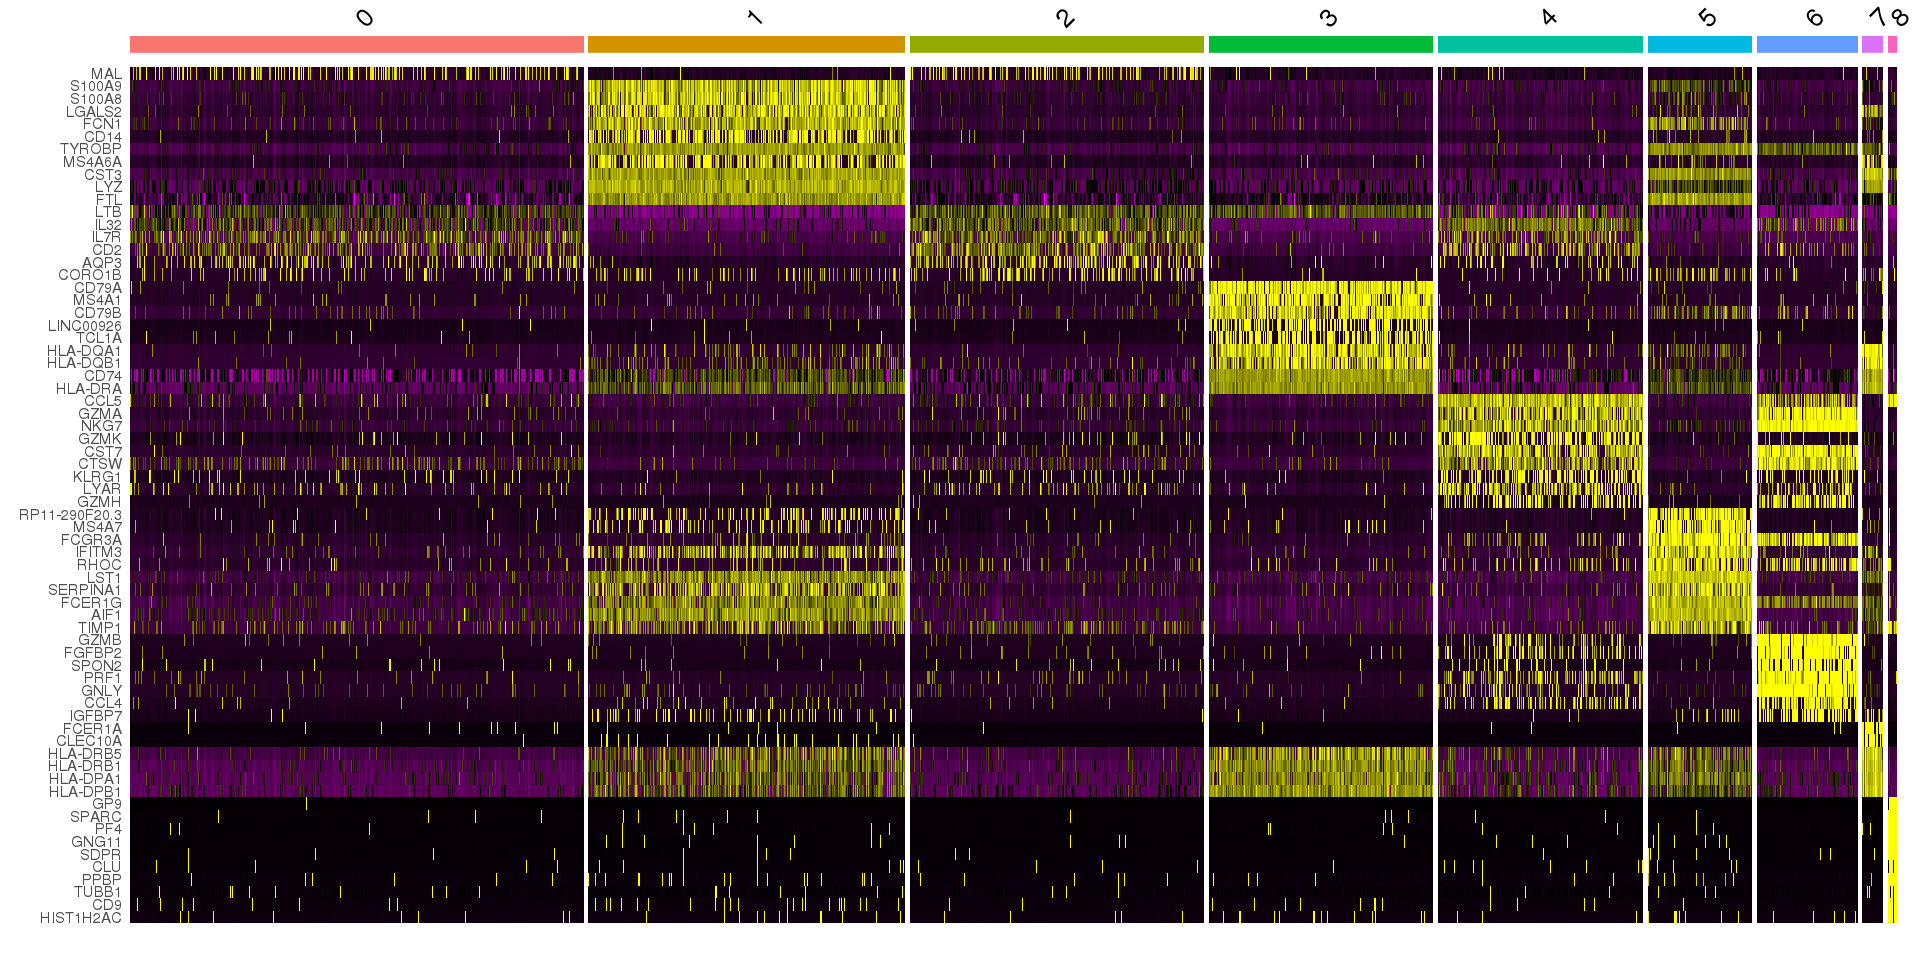

In [28]:
pbmc.markers %>% group_by(cluster) %>% top_n(n = 10, wt = avg_log2FC) -> top10
DoHeatmap(pbmc, features = top10$gene) + NoLegend()

***
# Assigning cell type identity to clusters

Fortunately in the case of this dataset, we can use canonical markers to easily match the unbiased clustering to known cell types:

Cluster ID | Markers       | Cell Type
-----------|---------------|----------
0          | IL7R, CCR7    | Naive CD4+ T 
1          | CD14, LYZ     | CD14+ Mono
2          | IL7R, S100A4  | Memory CD4+ 
3          | MS4A1         | B 
4          | CD8A          | CD8+ T 
5          | FCGR3A, MS4A7 | FCGR3A+ Mono
6          | GNLY, NKG7    | NK 
7          | FCER1A, CST3  | DC
8          | PPBP          | Platelet


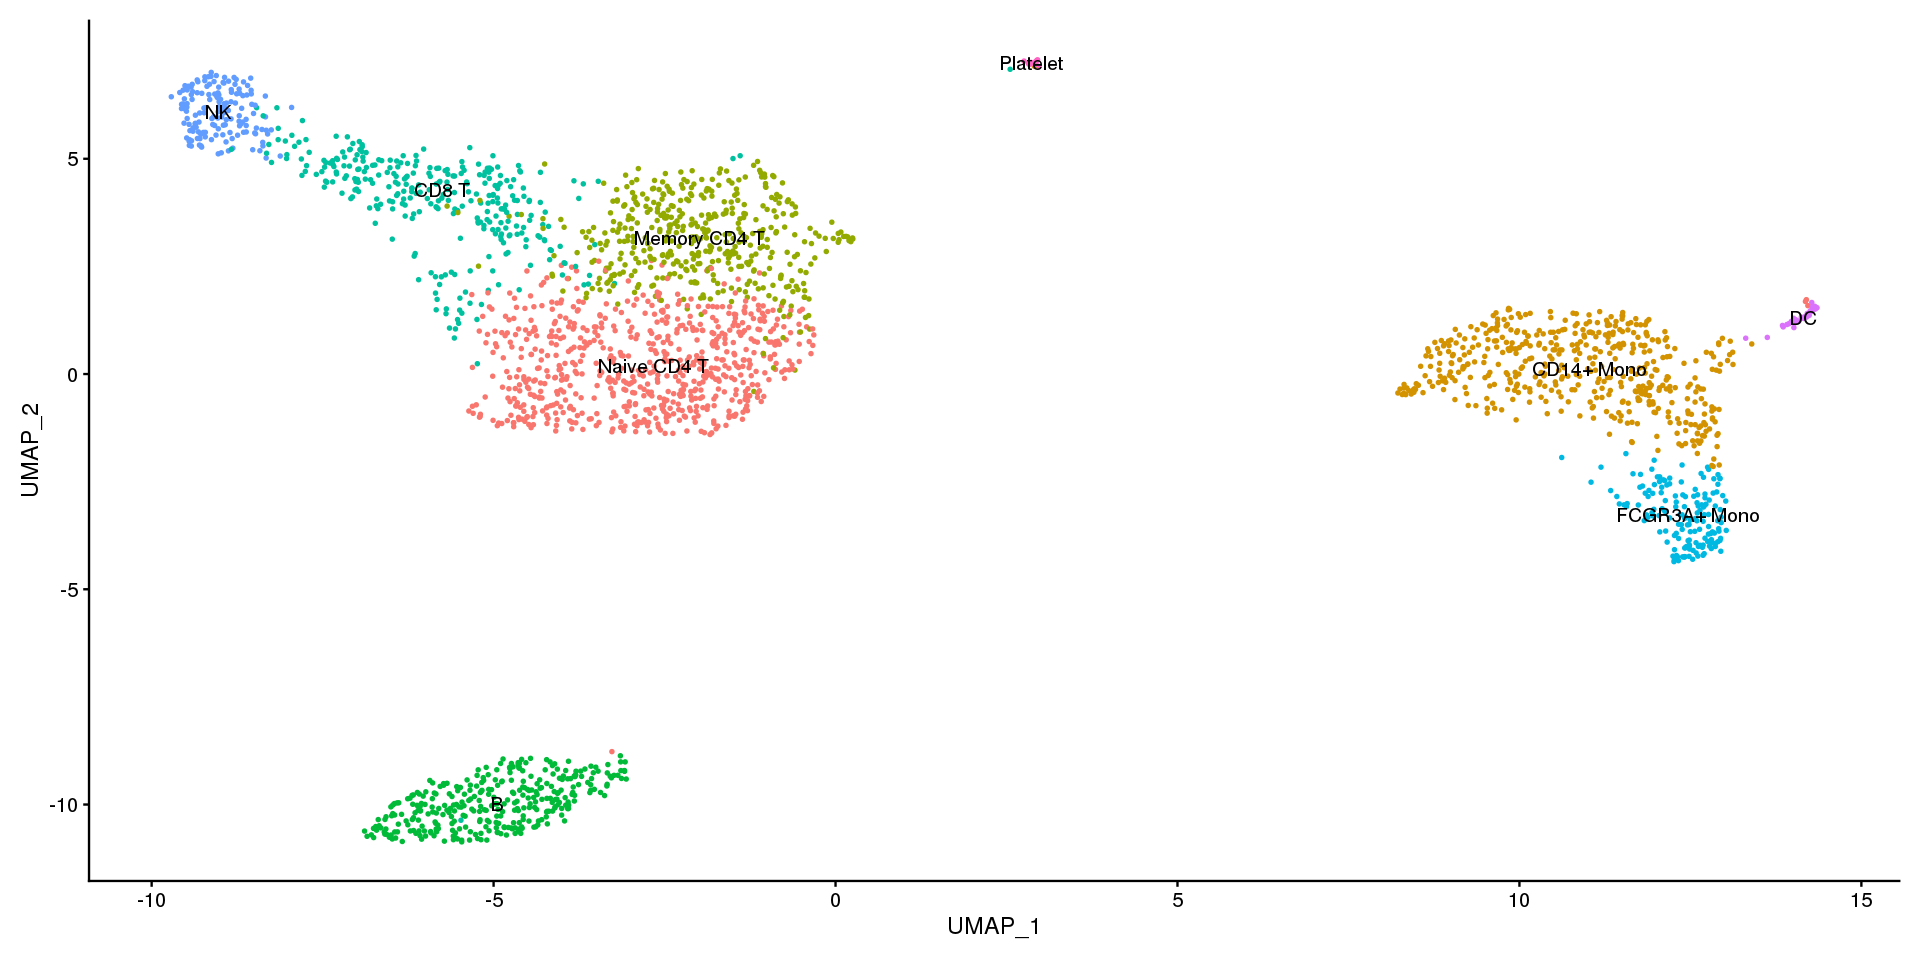

In [29]:
new.cluster.ids <- c("Naive CD4 T", "CD14+ Mono", "Memory CD4 T", "B", "CD8 T", "FCGR3A+ Mono", "NK", "DC", "Platelet")
names(new.cluster.ids) <- levels(pbmc)
pbmc <- RenameIdents(pbmc, new.cluster.ids)
DimPlot(pbmc, reduction = 'umap', label = TRUE, pt.size = 0.5) + NoLegend()

In [30]:
library(ggplot2)
plot <- DimPlot(pbmc, reduction = "umap", label = TRUE, label.size = 4.5) + xlab("UMAP 1") + ylab("UMAP 2") + 
  theme(axis.title = element_text(size = 18), legend.text = element_text(size = 18)) + 
  guides(colour = guide_legend(override.aes = list(size = 10)))
ggsave(filename = "../output/images/pbmc3k_umap.jpg", height = 7, width = 12, plot = plot, quality = 50)

In [31]:
saveRDS(pbmc, file = "../output/pbmc3k_final.rds")

In [33]:
#saveRDS(pbmc, file = "../data/pbmc3k_final.rds")

In [35]:
#write.csv(x = t(as.data.frame(all_times)), file = "../output/timings/pbmc3k_tutorial_times.csv")

<details>
  <summary>**Session Info**</summary>

In [36]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /usr/local/intel/compilers_and_libraries_2020.2.254/linux/mkl/lib/intel64_lin/libmkl_rt.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] ggplot2_3.3.4      patchwork_1.1.1    SeuratObject_4.0.2 Seurat_4.0.3      
[5] dplyr_1.0.5       

loaded via a namespace (and not attached):
  [1] Rtsne_0.15            colorspace_2.0-1      deldir_0.2-10        
  [4] ellipsis_0.3.2        ggridges_0.5.3        IRdispla

</details>